# E3. LINEAR REGRESSION(STEPWISE SELECTION)

__1. Importing Libraries and Datasets__

__2. Stepwise Selection__

__3. Linear Regression__

__4. Model Evaluation : Training Metrics__

__5. Model Evaluation : Cross Validation__

__6. Model Evaluation : Test Dataset__

__7. Residuals' Distribution__

__8. Scatterplots with fitted line (Train Dataset)__

__9. Saving Results__

## 1.Importing Libraries and Datasets

In [1]:
# Libraries

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

import shap
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', 100)

In [2]:
# Train Dataset

train_data = pd.read_csv("BG_Train_Dataset.csv") 
train_df = train_data.copy()
train_df.head(1)

,Age,BMI,Smoking,Pre Operative Fast,Pre Operative Glucose,Sex,Cort,LV,ASA,Post Operative Glucose
0,3.346,4.337,1.549,5.791,7.307,1,1,1,2,129


In [3]:
# Obtaining the train dataframe shape 

train_df.shape

(200, 10)

In [4]:
# Test Dataset

test_data = pd.read_csv("BG_Test_Dataset.csv") 
test_df = test_data.copy()
test_df.head(1)

,Age,BMI,Smoking,Pre Operative Fast,Pre Operative Glucose,Sex,Cort,LV,ASA,Post Operative Glucose
0,4.165,5.322,0.0,8.05,6.734,0,0,1,3,130


In [5]:
# Obtaining the test dataframe shape 

test_df.shape

(35, 10)

In [6]:
# Defining X_train and Y_train

Y_train = train_df['Post Operative Glucose']
X_train = train_df.drop('Post Operative Glucose', axis = 1)
X_train.head(1)

,Age,BMI,Smoking,Pre Operative Fast,Pre Operative Glucose,Sex,Cort,LV,ASA
0,3.346,4.337,1.549,5.791,7.307,1,1,1,2


## 2. Stepwise Selection

In [7]:
# Function the performs stepwise selection

def stepwise_selection(data, target,SL_in=0.05,SL_out = 0.05):
    initial_features = data.columns.tolist()
    best_features = []
    while (len(initial_features)>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value<SL_in):
            best_features.append(new_pval.idxmin())
            while(len(best_features)>0):
                best_features_with_constant = sm.add_constant(data[best_features])
                p_values = sm.OLS(target, best_features_with_constant).fit().pvalues[1:]
                max_p_value = p_values.max()
                if(max_p_value >= SL_out):
                    excluded_feature = p_values.idxmax()
                    best_features.remove(excluded_feature)
                else:
                    break 
        else:
            break
    return best_features

In [8]:
# Which variables are important according to stepwise selection

imp_vars = stepwise_selection(X_train, Y_train)
imp_vars

['Pre Operative Glucose',
 'Pre Operative Fast',
 'Cort',
 'LV',
 'Sex',
 'Age',
 'Smoking']

In [9]:
# Keeping only the important variables

X_train = X_train[imp_vars]

In [10]:
# Displaying X_train

X_train.head()

,Pre Operative Glucose,Pre Operative Fast,Cort,LV,Sex,Age,Smoking
0,7.307,5.791,1,1,1,3.346,1.549
1,7.952,7.283,0,1,1,4.302,1.647
2,6.949,5.750,0,1,0,4.097,0.675
3,6.376,6.731,0,1,1,3.892,0.000
4,6.519,5.791,0,1,1,3.687,0.000


## 3. Linear Regression

In [11]:
# Adding constant

X_train_with_constant = sm.add_constant(X_train)
X_train_with_constant.head(1)

,const,Pre Operative Glucose,Pre Operative Fast,Cort,LV,Sex,Age,Smoking
0,1.0,7.307,5.791,1,1,1,3.346,1.549


In [12]:
# Fitting the model and printing summary

MLRmodel = sm.OLS(Y_train, X_train_with_constant).fit()
print(MLRmodel.summary())

                              OLS Regression Results                              
Dep. Variable:     Post Operative Glucose   R-squared:                       0.428
Model:                                OLS   Adj. R-squared:                  0.407
Method:                     Least Squares   F-statistic:                     20.49
Date:                    Wed, 24 Jul 2024   Prob (F-statistic):           1.94e-20
Time:                            14:15:37   Log-Likelihood:                -929.00
No. Observations:                     200   AIC:                             1874.
Df Residuals:                         192   BIC:                             1900.
Df Model:                               7                                         
Covariance Type:                nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

## 4. Model Evaluation : Training Metrics

In [13]:
# Getting predictions and training error metrics 

MLRpredictions = MLRmodel.predict(X_train_with_constant)

MLR_Tr_MAE = np.round(mean_absolute_error(Y_train, MLRpredictions),2)

In [14]:
# Dictionary that holds the information of R^2, adjusted R^2, F-statistic value, number of predictors 
# and training error metric values 

dict1 = {'Linear Regression (Stepwise Selection)': (np.round(MLRmodel.rsquared,3),np.round(MLRmodel.rsquared_adj,3), 
                 np.round(MLRmodel.fvalue,2), 
                 np.round(len(X_train.columns),3),
                 MLR_Tr_MAE)}

In [15]:
# Creating a dataframe to easily present the results 

Training_metric_df = pd.DataFrame(dict1, index=['R^2','adj.R^2','F-stat', 
                                               'Num_of_Feats', 'Tr_MAE'])

In [16]:
# Displaying the training evaluation metrics

Training_metric_df

,Linear Regression (Stepwise Selection)
R^2,0.428
adj.R^2,0.407
F-stat,20.490
Num_of_Feats,7.000
Tr_MAE,17.620


## 5. Model Evaluation : Cross Validation

In [17]:
# Using the KFold function for cross-validation

cv = KFold(n_splits = 5, shuffle = True, random_state = 126)

In [18]:
# Function that calculates the cross validated test MAE 

def cv_scores(X,Y, model,cv):
        
    cv_MAE = round(np.mean(cross_val_score(model, X, Y, cv=cv, 
                                       scoring='neg_mean_absolute_error', 
                                           error_score='raise') * (-1)),2)

    
    score = cv_MAE
    return score

In [19]:
# Dictionary that holds the information of the cross validated test MAE 

dict2 = {'Linear Regression (Stepwise Selection)':cv_scores(X_train,Y_train,LinearRegression(),cv)}

In [20]:
# Creating a dataframe to easily present the results 

Test_CV_results = pd.DataFrame(dict2, index=['Te_MAE (KFold)'])

In [21]:
# Displaying the cross validated test error results

Test_CV_results

,Linear Regression (Stepwise Selection)
Te_MAE (KFold),18.45


## 6. Model Evaluation : Test Dataset

In [22]:
# Defining X_test and Y_test

Y_test = test_df['Post Operative Glucose']
X_test = test_df.drop('Post Operative Glucose', axis = 1)
X_test.head(1)

,Age,BMI,Smoking,Pre Operative Fast,Pre Operative Glucose,Sex,Cort,LV,ASA
0,4.165,5.322,0.0,8.05,6.734,0,0,1,3


In [23]:
X_test = X_test[imp_vars]
X_test.head()

,Pre Operative Glucose,Pre Operative Fast,Cort,LV,Sex,Age,Smoking
0,6.734,8.050,0,1,0,4.165,0.000
1,6.089,7.922,0,1,0,5.326,2.866
2,8.453,5.709,0,1,1,4.848,0.000
3,7.092,5.709,0,1,1,5.189,0.000
4,8.023,5.791,0,1,0,3.824,0.000


In [24]:
# Adding constant

X_test_with_constant = sm.add_constant(X_test)

In [25]:
# Getting predictions

MLR_predictions = MLRmodel.predict(X_test_with_constant)

In [26]:
# Getting Test Metrics

MLR_Te_MAE = round(mean_absolute_error(Y_test, MLR_predictions),2)

In [27]:
# Dictionary that holds the information of test MAE 

dict3 = {'Linear Regression (Stepwise Selection)':[MLR_Te_MAE]}

In [28]:
# Creating a dataframe to easily present the results 

Test_Dat_results = pd.DataFrame(dict3, index=['Te_MAE'])

In [29]:
# Displaying the test error results

Test_Dat_results

,Linear Regression (Stepwise Selection)
Te_MAE,19.81


## 7. Residuals' Distribution

In [30]:
# model fitted values

fitted_y1 = MLRmodel.fittedvalues

# model residuals
residuals1 = MLRmodel.resid

In [31]:
color = 'red'

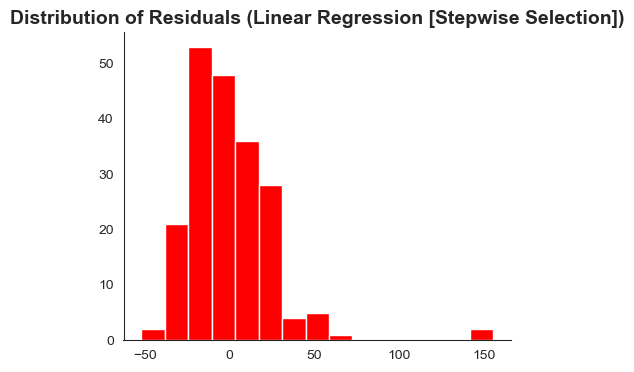

In [32]:
# Histogram of residuals 

sns.set_style("white")
    
plt.figure(figsize=(5,4))
    
plt.hist(residuals1, bins = 15, color = color)
    
plt.title(label = "Distribution of Residuals (Linear Regression [Stepwise Selection])" , fontsize = 14, weight = 'bold')
    
sns.despine()
    
plt.show()

## 8. Scatterplots with fitted line (Train Dataset)

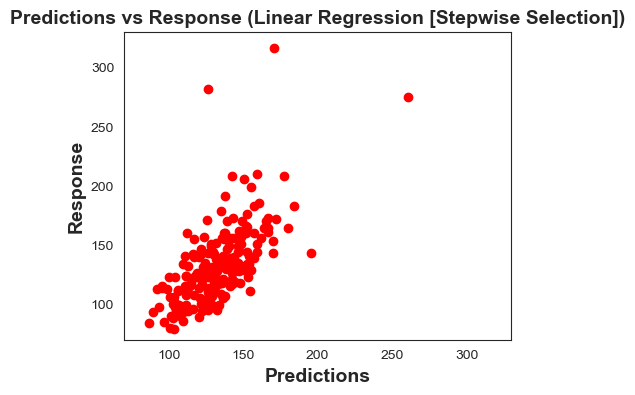

In [33]:
# Plotting predictions vs response 

sns.set_style("white")

plt.figure(figsize=(5,4))

plt.plot(MLRpredictions, Y_train, 'o', color = color)

# Uncomment the following lines to add a fitted line
# b,a = np.polyfit(MLRpredictions, Y_train, 1)

# plt.plot(MLRpredictions, b*MLRpredictions + a, color = 'black')

plt.title(label = 'Predictions vs Response (Linear Regression [Stepwise Selection])', fontsize = 14, weight = 'bold')
plt.xlabel('Predictions',fontsize = 14, weight = 'bold')
plt.ylabel('Response',fontsize = 14, weight = 'bold')

plt.xlim(70, 330)
plt.ylim(70, 330)

plt.show()

## 9. Saving Results

In [34]:
# Concatenating the training and test Dataframes

LinearModelsResults = pd.concat([Training_metric_df, Test_CV_results,Test_Dat_results], axis =  0)
LinearModelsResults

,Linear Regression (Stepwise Selection)
R^2,0.428
adj.R^2,0.407
F-stat,20.490
Num_of_Feats,7.000
Tr_MAE,17.620
Te_MAE (KFold),18.450
Te_MAE,19.810


In [35]:
# Saving the Results

LinearModelsResults.to_csv(r'LinearModelsResultsStepwiseSelection.csv', index=True, index_label = 'Metric')